# Dependencies

In [38]:
import os
import pathlib
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
import keras
import pickleshare
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [ ]:
with open('202001-citibike-tripdata_1.csv', 'r') as file:
    df_base = pd.read_csv(file, parse_dates=['started_at', 'ended_at'])

%store df_base

In [ ]:
%store -r df_base

# Data prep

In [7]:
df_base['day'] = df_base['started_at'].dt.day
df_base['hour'] = df_base['started_at'].dt.hour
df_base['weekday'] = df_base['started_at'].dt.dayofweek
df_base['trip_duration'] = (df_base['ended_at'] - df_base['started_at']).dt.total_seconds()

In [8]:
df_agg = df_base.groupby(['start_station_id','day','hour', 'weekday']).agg(
    trip_amount=('ride_id', 'count'),  # Count of 'ride_id'
    avg_trip_duration=('trip_duration', 'mean'),  # Average of 'trip_duration'
  ).reset_index()

In [9]:
df_one_hot = pd.get_dummies(df_agg, columns=['start_station_id'], prefix="start_station_id", dummy_na=False)

In [11]:
X = df_one_hot.drop("trip_amount", axis=1)
Y = df_one_hot["trip_amount"]

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
NUMERICAL_COLUMNS = ['day', 'hour', 'avg_trip_duration']
CATEGORICAL_COLUMN = 'weekday'

In [14]:
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train)
X_test_scaled_np = scaler.transform(X_val)

In [20]:
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=X_val.columns, index=X_val.index)

In [15]:
input_shape = (X_train_scaled_np.shape[1],)

# Training

In [17]:
model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape), # Define the input shape
        layers.Normalization(axis=-1), # This layer would need to be .adapt()-ed
        layers.Dense(64, activation="relu", name="dense_1"),
        layers.Dropout(0.3), # Dropout for regularization
        layers.Dense(32, activation="relu", name="dense_2"),
        layers.Dropout(0.2),
        layers.Dense(1, name="output_layer"),  # Output layer for regression (1 neuron, linear activation by default)
    ]
)

e:\TCC\.venv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",  # Common loss for regression
    metrics=["mean_absolute_error"],  # MAE is easier to interpret
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 1793)           │         3,587 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,516 (470.77 KB)

 Trainable params: 116,929 (456.75 KB)

 Non-trainable params: 3,587 (14.02 KB)

In [21]:
history = model.fit(
    X_train_scaled,
    Y_train,
    epochs=50,  # Adjust as needed
    batch_size=32, # Adjust as needed
    validation_split=0.2,  # Use part of training data for validation during training
    verbose=1, # Set to 0 for less output, 1 for progress bar
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 5.5776 - mean_absolute_error: 1.4496 - val_loss: 4.9552 - val_mean_absolute_error: 1.2896
Epoch 2/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 4.6817 - mean_absolute_error: 1.3236 - val_loss: 4.4894 - val_mean_absolute_error: 1.2606
Epoch 3/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 4.4011 - mean_absolute_error: 1.2827 - val_loss: 4.3062 - val_mean_absolute_error: 1.2213
Epoch 4/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 4.2685 - mean_absolute_error: 1.2715 - val_loss: 4.2470 - val_mean_absolute_error: 1.2106
Epoch 5/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 4.1578 - mean_absolute_error: 1.2559 - val_loss: 4.0625 - val_mean_absolute_error: 1.2000
Epoch 6/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 4.1863 - mean_absolute_error: 1.2539 - val_loss: 4.0804 - val_mean_absolute_error: 1.1960
Epoch 7/50
8309/8309 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 4.1576 - mean_absol

# Evaluation

In [27]:
y_pred_test = model.predict(X_test_scaled).flatten() 

2597/2597 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step


In [23]:
loss, mae = model.evaluate(X_test_scaled, Y_val, verbose=0)

In [24]:
loss

3.2880873680114746

In [25]:
mae

1.1273658275604248

In [29]:
mse_sklearn = mean_squared_error(Y_val, y_pred_test)
mse_sklearn

3.2880883930988687

In [30]:
rmse = np.sqrt(mse_sklearn)
rmse

1.813308686655107

In [31]:
mae_sklearn = mean_absolute_error(Y_val, y_pred_test)
mae_sklearn

1.1273659413245005

In [33]:
def mean_absolute_percentage_error_manual(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return mean_absolute_percentage_error(y_true, y_pred) * 100 # as percentage

In [34]:
mape = mean_absolute_percentage_error_manual(Y_val, y_pred_test)
mape

56.33133109919493

In [ ]:
r2 = r2_score(Y_val, y_pred_test)
r2

0.44105519863987075

In [36]:
print("\n--- Quick Summary of Test Metrics ---")
print(f"  MSE:  {mse_sklearn:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae_sklearn:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²:   {r2:.4f}")


--- Quick Summary of Test Metrics ---
  MSE:  3.2881
  RMSE: 1.8133
  MAE:  1.1274
  MAPE: 56.33%
  R²:   0.4411


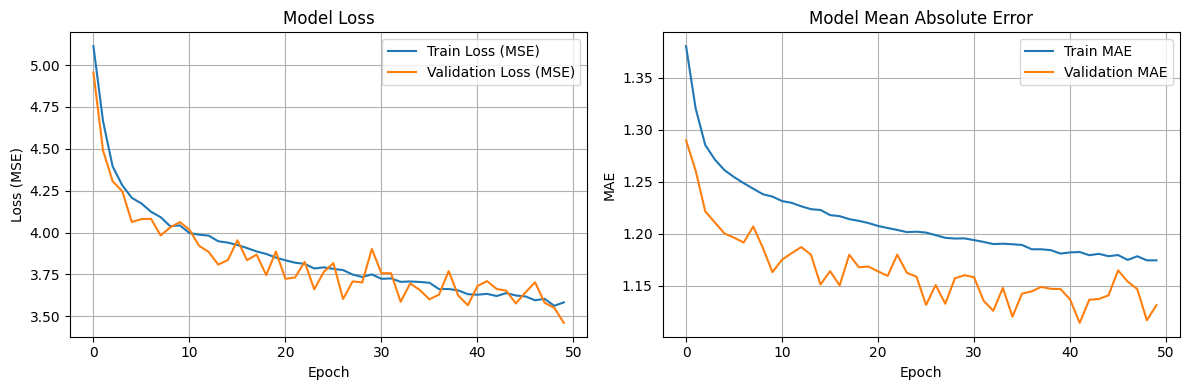

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()